## NLP Coursework - Text Classification - Craig Miles-Clarke

### Imports

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import re
import string
import spacy
import demoji

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV 

nlp = spacy.load('en_core_web_sm')
random_seed = 60

## 1. Introduction

### 1.1 Introduction to the domain-specific area

Using live data provided by social media to understand crises has been a subject of academic interest for a number of years. In their research, Starbird et al (2010) claimed to have uncovered a 'new framing of the relationship between emergency response and communications by members of the public: That official information remains important and is complemented, not usurped, by information generated by the public'. As Li et al (2017) have noted 'microblogging data from Twitter-like platforms are seen to have intrinsic value for both responder organizations and victims, due to their growing ubiquity, communications rapidity, and cross-platform accessibility.' The real-time data that social media platforms provide can give us valuable insights to events that are taking place at any given moment in time in ways that we cannot achieve through other means of communication. Albeit a very sparse account of how this plays out, BBC Trending's report on the 2015 attacks in Paris combines social media posts across a range of platforms to piece together the timeline of events from a citizen's-eye view (BBC Trending, 2015). Said report was compiled after the event, but strategies could be employed to survey natural or humanmade crises as they are unfolding. The potential benefits of this include, but are not limited to:

- Who: learn the identities of the people who may been involved. We may want to contact them to provide assistance or to ask them for information
- What: gain a more detailed understanding about the specific nature of the crisis, including its severity and associated risks
- Where: establish where the crisis is taking place and whether it is static or moving in one or more directions
- When: understand the timeline of events
- Why: use social media data to understand the cause(s) of a crisis

Using the data gleaned from social media, we may be able to respond to the events in a more purposeful way; directing support and resources to the people and places who need them most. Following the event, the data collected could be used to understand how events played out. Said understanding could be used to improve crisis- and disaster-prevention strategies and responses in the future.

However, there are significant challenges when working with such data. As Caragea et al (2016) explain 'with the exponential increase in the volume of social media data, so comes the increase in data that are irrelevant to a disaster, thus, diminishing peoples’ ability to find the information that they need in order to organize relief efforts, find help, and potentially save lives'. Therefore developing tools which are effective at identifying nd categorising data which are relevant becomes an important goal.

### 1.2 Description of the selected dataset

The data set used in this piece of work is titled 'Disaster Tweet Corpus 2020' (Wiegmann et al 2020). It is available from Zenodo, a general-purpose open repository developed under the European OpenAIRE program and operated by The European Organization for Nuclear Research (CERN). The entire data set consists of 48 newline delimited JSON (ndjson) files covering 10 different disaster types. These include earthquakes, tsunamis, and humanmade industrial disasters. Each data set contains an even split of disaster-related and non-disaster-related tweets. They are human labelled, with a 1 indicating that the tweet relates to a disaster, and a 0 indicating that the opposite is true. As well as the tweet text and classification, a third variable, the user id, is also included. The data sets are intended to be used for benchmarking for filtering algorithms. Therefore, they meet the needs of the scope of this work.

Though the entire corpus consists of 48 files, I will instead work with 6 files which contain a total of 9630 tweets. These cover 6 different types of disaster (pandemic, flood, earthquake, industrial fire, train crash and forest fire) across 6 different continents (Africa, Asia, North America, South America, and Europe). A corpus of this size will give me sufficient data to train and test my models. 

By combining data sets from different types of disaster, theoretically it should make the trained model more robust when classifying a variety of catastrophic events.

The data set has been partially transformed. For example, hashtags have been replaced with '<HASHTAG>' while numbers are similarly recorded as '<NUMBER>'. Emojis and URLS appear throughout the data set. I detail my approach to pre-processing the data in section 2.1 below.

### 1.3 Objectives of the project

Crisis-mapping has been an area of academic interest for a number of years, studying both those impacted directly by the emergencies as well as those coordinating efforts to support them (Kaufhold and Reuter, 2016).

With the world facing a climate emergency, and an increase in extreme weather events predicted (NASA, 2022), the need to be able to anticipate, observe and respond to crises is more urgent than ever. Indeed, while the future may look increasingly challenging regarding extreme weather events, many countries have been experiencing an increase in both the number and severity of such events for a number of years.

Social media is now a fundamental vehicle through which humans exchange information, with many people using it as a means to access and report information about emergencies and disasters. Given its widespread adoption among younger people, and an increasing use of it amongst older people, the use of social media to both report on events and request assistance is likely to increase (Canadian Red Cross, 2012). Indeed, given the date of this report, it is not unreasonable to assume that the adoption of this technology and expectations surrounding it will have increased significantly since. Lindsay (2016) notes that younger people 'are also more likely to request help through social media, believe agencies should monitor their postings, and have high expectations that agencies will respond quickly to their requests'. He argues that it is incumbent on emergency managers and officials to respond to the needs, behaviours and expectations of the public. 

During periods of crisis, responders will be working with vast quantities of data. Given the urgency of the situation at hand, there is little time to process this data. Reflecting on the response to the 2010 Haiti earthquake, Li et al (2017) identify several challenges the responders faced when working with data to inform their work. These were:

- policies were not in place to accept data from outside their networks
- the significant volume and speed at which they were receiving data
- lack of technical staff or analytical tools to work with the data

Therefore, the combination of changing human attitudes and behaviours, an increase in extreme weather events, and the continued embedding of technology in the lives of humans, justifies the research and advancement of tools which enable us to respond to these events in a more proactive, agile, and purposeful manner. To this end, I intend to create a text classifier which is able to distinguish between social media communications, specifically tweets, which relate to emergencies and those that do not. When employed in a crisis, this approach could support reponders to get to the most relevant information in the shortest time possible, resulting in better outcomes to those affected.

### 1.4 Evaluation methodology

Throughout this work, I will use the term 'effectiveness' when evaluating the text classification models I create and their associated measures. As Manning et al (2009) state, 'many researchers mean effectiveness, not efficiency of text classification when they use the term performance', with the latter relating to computational efficiency.

For each model, I will produce a confusion matrix and an associated classification report. This will allow me to observe the model's effectiveness regarding accuracy, precision, recall and F1-score. In turn, they are defined as follows:

$ Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

$ Precision = \frac{TP}{TP+FP}$

$ Recall = \frac{TP}{TP+FN}$

$ F1-score = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$

Given that the data set I am working with is balanced, concerns around the validity of the accuracy measure are not a concern. As Manning, Raghavan, and Schutze (2009) note, 'the always-no classifier is 99% accurate for a class with relative frequency 1%'.

At the risk of stating the obvious, choosing an appropriate measure by which to evaluate a model is specific to the data and goals of the work being carried out. For example, if I was working with an imbalanced data set where the target class was rare, I would be minded to use a macro-averaged F1-score as it would treat each class equally. As Narasimhan et al (2016) note, it 'is very popular in many classification and retrieval problems due to its emphasis on performing well on rare classes.' In simple terms, the macro-averaged F1-score treats each class equally, regardless of the sample size. In this theoretical instance, a micro-averaged F1-score would give greater emphasis to the majority class and would skew the results of the effectiveness of the model. 

On the other hand, if I was concerned about the overall accuracy of a model, a micro-averaged F1-score could be appropriate as it would give equal importance to each sample in the training data. 

In this piece of work, I will be using the macro-averaged F1-score to compare the effectiveness of each model. Again, due to the fact that my data set is balanced, choosing between the micro- and macro-averaged F1-score is somewhat arbitrary given that they will produce identical results due to the sample sizes being the same. This score is the weighted harmonic mean of precision and recall. It is also a conservative measure as it is closer to the lower of the two values than the arithmetic mean (Jurafsky and Martin, 2023).

## 2. Implementation

### 2.1 Pre-processing

The ndjson files have been stored locally. The program below reads multiple JSON files located in a specified directory, creates individual DataFrames for each file, stores them in a list, concatenates them into a single DataFrame (tweets), and resets the index of the DataFrame. The final step ensures that data do not share row indices within the DataFrame.

As outlined above, the data set has already been partially transformed, with hashtags and numerals being replaced by capitalised text enclosed in angle brackets, for example. These must be removed from the data as they could interfere with the accuracy of the model.

The data has undergone several stages of pre-processing. This was achieved by defining several functions for each data preparation task, before combining them in one larger function to carry out the pre-processing wholesale. This was an iterative process, which was supported by my exploratory data analysis below. By visualising the ways in which the data was being processed by my program, I was able to further refine it in order to achieve my desired outcomes. Text was converted to lower case, with URLs, punctuation, and special characters removed. The text was lemmatized. By reducing words to their root form, this should help improve the accuracy of my classification models as it reduces the dimensionality of my data. The pre-processed text data was stored as a separate variable.

In the classifiers and their associated pipelines below, I have adopted the following approaches to pre-processing the data.

**Naive Bayes bag of words classifier (baseline):**
Here, I will preproces the text data using a count vectorizer. This transforms the text data to a sparse matrix of token counts.

**Naive Bayes tf-idf classifier:**
When implementing this classifier, I will pre-process the data using a tf-idf vectorizer. This will transform a count matrix to a normalized tf-idf representation.

**Support vector classifier (SVC) tf-idf classifier:**
When implementing this classifier I will once again pre-process the data using a tf-idf vectorizer.

**Hyperparameter-tuned SVC tf-idf classifier:**
This classifier will follow the same pre-processing steps as above, but I will use grid search to help define the most effective combination of hyperparameters for the algorithm.


In [2]:
# Read the ndjson files and store them in a pandas DataFrame.
path = '/Users/craigmiles-clarke/Module 3: NLP/Coursework'
files = glob.glob(path + '/*.ndjson')

list = []

for f in files:
    temp_df = pd.read_json(f, lines = True)
    list.append(temp_df)
    print(f'Successfully created dataframe for {f} with shape {temp_df.shape}')
    
tweets = pd.concat(list, axis =0).reset_index(drop=True)
print(tweets.shape)
tweets.head()

Successfully created dataframe for /Users/craigmiles-clarke/Module 3: NLP/Coursework/biological-ebola-2014.ndjson with shape (3448, 3)
Successfully created dataframe for /Users/craigmiles-clarke/Module 3: NLP/Coursework/transportation-spain-train-crash-2013.ndjson with shape (704, 3)
Successfully created dataframe for /Users/craigmiles-clarke/Module 3: NLP/Coursework/industrial-venezuela-refinery-fire-2012.ndjson with shape (124, 3)
Successfully created dataframe for /Users/craigmiles-clarke/Module 3: NLP/Coursework/wildfire-california-2014.ndjson with shape (2908, 3)
Successfully created dataframe for /Users/craigmiles-clarke/Module 3: NLP/Coursework/flood-srilanka-2017.ndjson with shape (1480, 3)
Successfully created dataframe for /Users/craigmiles-clarke/Module 3: NLP/Coursework/earthquake-iraq-iran-2017.ndjson with shape (966, 3)
(9630, 3)


,id,text,relevance
0,'497086296385675264',<HASHTAG> ebola symptoms. early treatment mean...,1
1,'497086297475805184',thinking about telling leadership to make indi...,1
2,'497086300781309952',"we know people are contracting the disease, an...",1
3,'497086305671864321',this is <USER> nurse <HASHTAG> <NUMBER> is at ...,1
4,'497086306443202560',you asked questions about ebola â€” and we hav...,1


In [3]:
# Remove the 'id' column as it serves no purpose for this classification task.
tweets.drop(columns='id', inplace = True)

In [4]:
# Define a series of functions which clean the text data ready for analysis.

In [ ]:
def lower_case(text):
    return text.lower()

In [6]:
def clean_URLs(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ', text)

In [7]:
def clean_angle_brackets(text):
    return re.sub(r'<\w+>', '', text)

In [8]:
def clean_numerals(text):
    return re.sub('[0-9]+', '', text)

In [9]:
def remove_emojis(text):
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item, '')
    return text

In [10]:
def remove_starting_space(text):
    if text.startswith(' '):
        text = text[1:]
    return text

In [11]:
def remove_stopwords_and_return_string(text):
    doc = nlp(text)
    cleaned_tokens = [token.text for token in doc if not token.is_stop]
    return ' '.join(cleaned_tokens)

In [12]:
def remove_punctuation(text):
    additional_chars = '“”‘’"¦…'
    all_punc = re.escape(string.punctuation + additional_chars)
    return re.sub(f"[{all_punc}]", '', text)

In [13]:
def remove_spec_chars(text):
    return re.sub(r'[â€—\x01]', '', text)

In [14]:
def tokenize_and_lemmatize(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return tokens

In [15]:
def join_strings(text):
    return ' '.join(text)

In [16]:
def remove_extra_spaces(text):
    return re.sub(r'\s{2,}', ' ', text)

In [17]:
def combined_clean(text):
    text = lower_case(text)
    text = clean_URLs(text)
    text = clean_angle_brackets(text)
    text = clean_numerals(text)
    text = remove_emojis(text)
    text = remove_starting_space(text)
    text = remove_stopwords_and_return_string(text)
    text = remove_punctuation(text)
    text = remove_spec_chars(text)
    text = tokenize_and_lemmatize(text) 
    text = join_strings(text)
    text = remove_extra_spaces(text)
    return text

In [18]:
# Apply the function to the corpus text.
tweets['clean_text'] = tweets['text'].apply(combined_clean)

In [19]:
# Check the DataFrame.
tweets

,text,relevance,clean_text
0,<HASHTAG> ebola symptoms. early treatment mean...,1,ebola symptom early treatment mean well chance...
1,thinking about telling leadership to make indi...,1,think tell leadership individual sign varsity ...
2,"we know people are contracting the disease, an...",1,know people contract disease die notice ebola
3,this is <USER> nurse <HASHTAG> <NUMBER> is at ...,1,nurse moment rush dallas atlanta ebola treatment
4,you asked questions about ebola â€” and we hav...,1,ask question ebola answer
...,...,...,...
9625,i'm about to walk out anyone tryna see me,0,walk tryna
9626,<USER> ugh cage i guess <HASHTAG> tvd,0,ugh cage guess tvd
9627,postcards from china 🇨🇳 <URL>,0,postcard china
9628,efit of suspect in an incident of sexual assau...,0,efit suspect incident sexual assault chigwell ...


In [20]:
len(tweets['clean_text'])

9630

In [21]:
tweets['relevance'].value_counts()

1    4815
0    4815
Name: relevance, dtype: int64

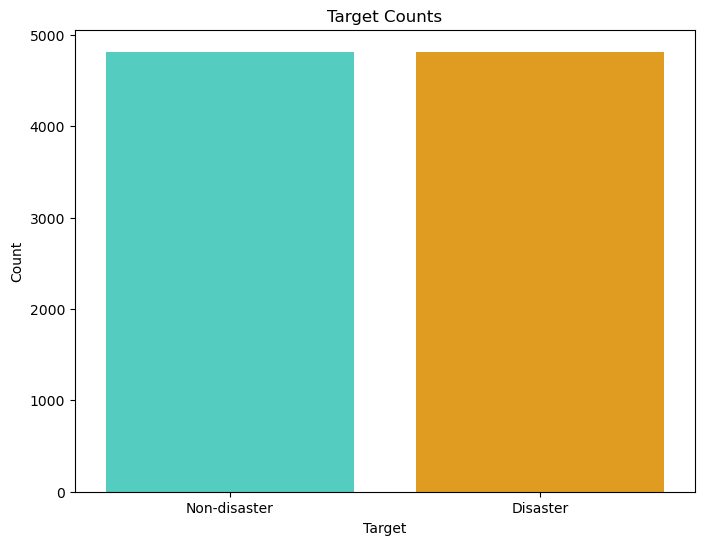

In [22]:
plt.figure(figsize=(8, 6))
sns.countplot(data=tweets, x='relevance', palette=['turquoise', 'orange'])
plt.title('Target Counts')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-disaster', 'Disaster'])
plt.show()

In [23]:
target_0_text = tweets[tweets['relevance'] == 0]['clean_text']
target_1_text = tweets[tweets['relevance'] == 1]['clean_text']

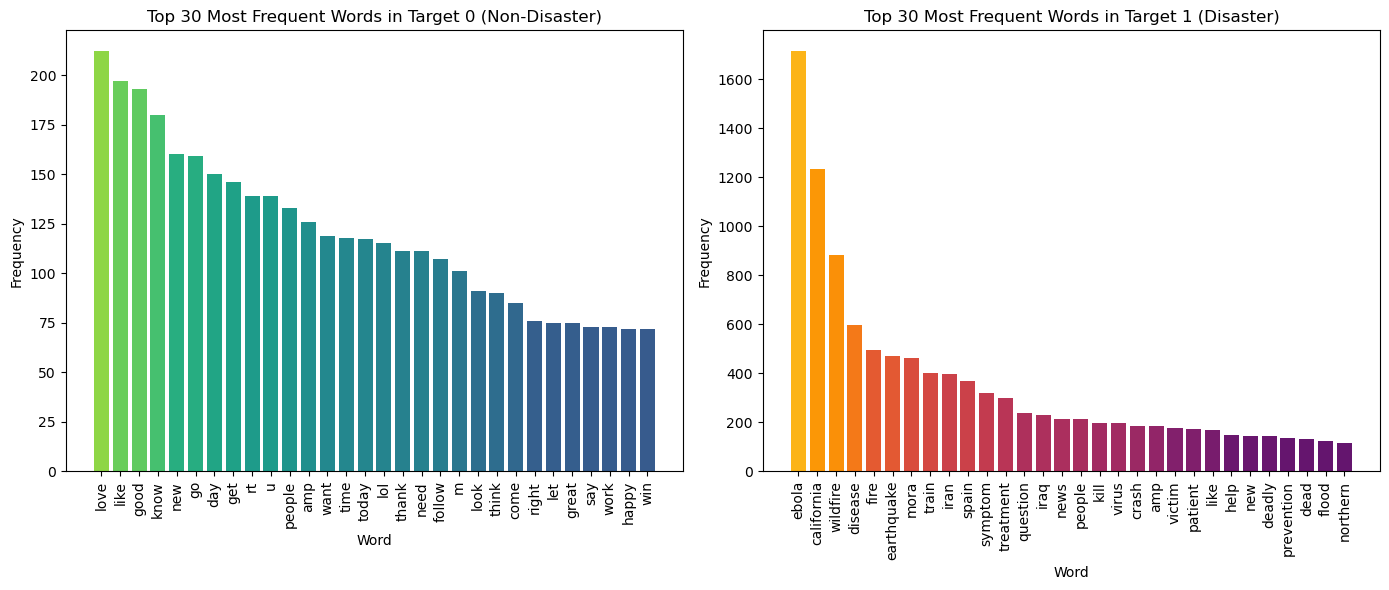

In [24]:
# Function to count words in a series of strings
def count_words(series):
    all_text = ' '.join(series)
    words = all_text.split()
    return pd.Series(words).value_counts().head(30)

# Count occurrences of words in target_0_text and target_1_text
word_counts_0 = count_words(target_0_text)
word_counts_1 = count_words(target_1_text)

# Create subplots for target_0_text and target_1_text
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for target_0_text
axes[0].bar(word_counts_0.index, word_counts_0.values, color=plt.cm.viridis(word_counts_0.values))
axes[0].set_title('Top 30 Most Frequent Words in Target 0 (Non-Disaster)')
axes[0].set_xlabel('Word')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=90)

# Plot for target_1_text
axes[1].bar(word_counts_1.index, word_counts_1.values, color=plt.cm.inferno(word_counts_0.values))
axes[1].set_title('Top 30 Most Frequent Words in Target 1 (Disaster)')
axes[1].set_xlabel('Word')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
# Briefly explore the lexical diversity of the corpora.

In [26]:
# Define a function to combine the strings of a text.
def combine_strings(text):
    all_text = ' '.join(text)
    return all_text

In [27]:
# Apply the function to the data.
combined_0_text = combine_strings(target_0_text)
combined_1_text = combine_strings(target_1_text)

In [28]:
# Define a function to calculate the lexical diversity of a corpus.
def lexical_diversity(text):
    return len(set(text)) / len(text)

In [29]:
# Call the function on the non-disaster tweets.
lexical_diversity(combined_0_text)

0.0029650611862282587

In [30]:
# Call the function on the disaster tweets.
lexical_diversity(combined_1_text)

0.0007435558493060145

I was surprised by this result. I assumed that the disaster-related tweets would comment on a narrower range of topics. Therefore, I expected their lexical diversity to be relatively small compared to tweets which could feasibly comment on any topic the user is interested in.

### 2.2 Baseline performance

I will use a multinomial naive Bayes classifier to establish baseline performance. This basic algorithm is fast and easy to implement which, while not always helpful in producing the most accurate models, will provide an effective starting point. Implementing a bag of words (BoW) approach using this algorithm has many well establish drawbacks, including ignoring the meaning of the text and instead relying on the frequencies of the words that appear in each document in the corpus. Once this baseline is established, I will refine my approach by using different classifiers and tuning the hyperparameters of said classifiers.

In [31]:
# Split the data into train and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(tweets.clean_text, tweets.relevance, test_size = 0.25, random_state = random_seed)

In [32]:
# Instantiate, fit and test the model.
BOW_model = make_pipeline(CountVectorizer(), MultinomialNB())
BOW_model.fit(X_train, Y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [33]:
BOW_model.score(X_test, Y_test)

0.8982558139534884

In [34]:
BOW_pred = BOW_model.predict(X_test)

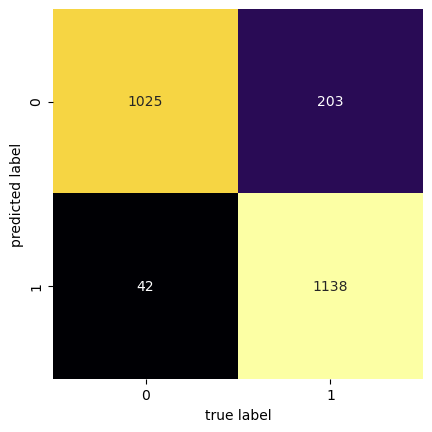

In [35]:
matrix = confusion_matrix(Y_test, BOW_pred)
sns.heatmap(matrix, square=True, annot=True, fmt='d', cmap='inferno', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [36]:
print(classification_report(Y_test, BOW_pred))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1228
           1       0.85      0.96      0.90      1180

    accuracy                           0.90      2408
   macro avg       0.90      0.90      0.90      2408
weighted avg       0.91      0.90      0.90      2408



The macro-averaged F1-score for this classifier is 0.90, thus representing the benchmark by which I will judge the effectiveness of the classifiers I implement below.

### 2.3 Classification approach

With a baseline macro-averaged F1-score of 0.90 for a naive Bayes classifer using a BoW approach, I will now move to implement two different approaches to the text classification problem with a view to achieving an improved macro-averaged F1-score.

The first will use a naive Bayes classifier once more, however this time I will preprocess the data using a tf-idf vectorizer. By using tf-idf instead of the frequencies of occurrence of a token in a given document (as in the BoW classifier) the intention is to dampen the impact of tokens that occur very frequently in a given corpus. Said tokens are likely to be less informative than features that occur in a small fraction of the training corpus.

Following this, I will harness the capabilties of support vector machines (SVM). These are a set of learning methods that can be effective when performing classification tasks. The SVM algorithm maps training vectors into a higher dimensional space before finding a linear separating hyperplane with the maximal margin in this higher dimensional space. I will implement a support vector classifier (SVC), once more using tf-idf vectorized data as the input. Grid search will help to define the best hyperparameters for the algorithm and thus optimise its effectiveness.

### 2.3.1 Naive Bayes tf-idf classifier

In [37]:
# Instantiate, fit and test the model.
TF_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
TF_model.fit(X_train, Y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [38]:
TF_model.score(X_test, Y_test)

0.8754152823920266

In [39]:
TF_model_pred = TF_model.predict(X_test)

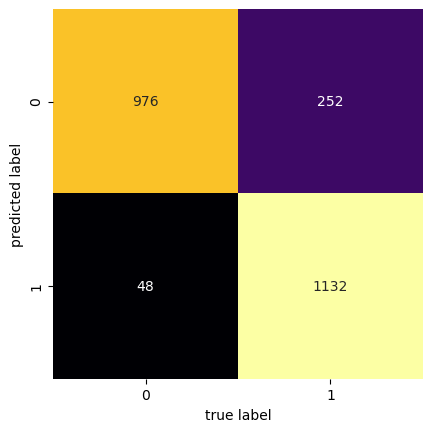

In [40]:
matrix = confusion_matrix(Y_test, TF_model_pred)
sns.heatmap(matrix, square=True, annot=True, fmt='d', cmap='inferno', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [41]:
print(classification_report(Y_test, TF_model_pred))

              precision    recall  f1-score   support

           0       0.95      0.79      0.87      1228
           1       0.82      0.96      0.88      1180

    accuracy                           0.88      2408
   macro avg       0.89      0.88      0.87      2408
weighted avg       0.89      0.88      0.87      2408



### 2.3.2 SVC tf-idf classifier

In [42]:
# Instantiate, fit and test the model.
SVC_model = SVC(random_state = random_seed)

In [43]:
# I was unable to combine the make_pipeline method with grid search, therefore
# performed each step in the pipeline separately.
TFIDF_vect = TfidfVectorizer()

In [44]:
# Fit and transform the training data but only transform the test data.
X_train_Tfidf = TFIDF_vect.fit_transform(X_train, Y_train)
X_test_Tfidf = TFIDF_vect.transform(X_test)

In [45]:
SVC_model.fit(X_train_Tfidf, Y_train)

SVC(random_state=60)

In [46]:
SVC_model.score(X_test_Tfidf, Y_test)

0.9713455149501661

In [47]:
SVC_pred = SVC_model.predict(X_test_Tfidf)

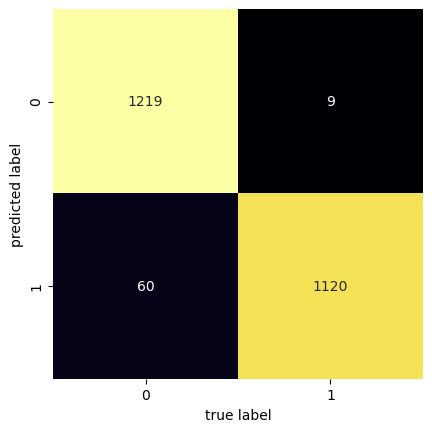

In [48]:
matrix = confusion_matrix(Y_test, SVC_pred)
sns.heatmap(matrix, square=True, annot=True, fmt='d', cmap='inferno', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [49]:
print(classification_report(Y_test, SVC_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1228
           1       0.99      0.95      0.97      1180

    accuracy                           0.97      2408
   macro avg       0.97      0.97      0.97      2408
weighted avg       0.97      0.97      0.97      2408



### 2.3.3 Hyperparameter-tuned SVC tf-idf classifier

In [50]:
# Define parameter grid and fit the model for grid search.
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear']}  
  
grid = GridSearchCV(SVC(), param_grid, refit= True, verbose= 3) 
  
grid.fit(X_train_Tfidf, Y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.949 total time=   1.2s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.943 total time=   1.2s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.945 total time=   1.3s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.947 total time=   1.2s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.941 total time=   1.2s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.949 total time=   1.2s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.943 total time=   1.2s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.945 total time=   1.3s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.947 total time=   1.2s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.941 total time=   1.2s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.949 total time=   1.2s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear

[CV 2/5] END ....C=1000, gamma=1, kernel=linear;, score=0.970 total time=   0.6s
[CV 3/5] END ....C=1000, gamma=1, kernel=linear;, score=0.967 total time=   0.6s
[CV 4/5] END ....C=1000, gamma=1, kernel=linear;, score=0.974 total time=   0.6s
[CV 5/5] END ....C=1000, gamma=1, kernel=linear;, score=0.972 total time=   0.6s
[CV 1/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.976 total time=   0.6s
[CV 2/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.970 total time=   0.6s
[CV 3/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.967 total time=   0.6s
[CV 4/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.974 total time=   0.6s
[CV 5/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.972 total time=   0.6s
[CV 1/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.976 total time=   0.6s
[CV 2/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.970 total time=   0.6s
[CV 3/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.967 total time=   0.7s
[CV 4/5] END .C=1000, gamma=

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear']},
             verbose=3)

In [51]:
# Print the best parameters after tuning 
print(grid.best_params_) 
  
# Print how the model looks following hyperparameter tuning 
print(grid.best_estimator_) 

{'C': 1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=1, gamma=1, kernel='linear')


In [52]:
grid.score(X_test_Tfidf, Y_test)

0.9754983388704319

In [53]:
grid_pred = grid.predict(X_test_Tfidf)

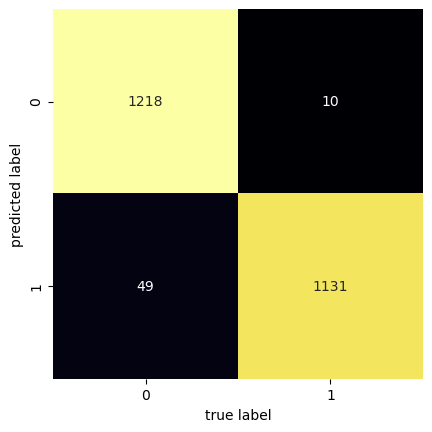

In [54]:
matrix = confusion_matrix(Y_test, grid_pred)
sns.heatmap(matrix, square=True, annot=True, fmt='d', cmap='inferno', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [55]:
print(classification_report(Y_test, grid_pred)) 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1228
           1       0.99      0.96      0.97      1180

    accuracy                           0.98      2408
   macro avg       0.98      0.98      0.98      2408
weighted avg       0.98      0.98      0.98      2408



## 3. Conclusions

### 3.1 Evaluation

The below table summarises the effectiveness of each of the classifiers.

In [56]:
# Recreate the confusion matrices for ease of comaprison.
model_names = ['Naive Bayes BoW (baseline)', 'Naive Bayes tf-idf', 'SVC tf-idf', 'Hyperparameter-tuned SVC tf-idf']
model_preds = [BOW_pred, TF_model_pred, SVC_pred, grid_pred]

for model, pred_labels in zip(model_names, model_preds):
    report = classification_report(Y_test, pred_labels)
    print(f"Classification Report for {model}:")
    print(report)
    print("-----------------------------------------------------")

Classification Report for Naive Bayes BoW (baseline):
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1228
           1       0.85      0.96      0.90      1180

    accuracy                           0.90      2408
   macro avg       0.90      0.90      0.90      2408
weighted avg       0.91      0.90      0.90      2408

-----------------------------------------------------
Classification Report for Naive Bayes tf-idf:
              precision    recall  f1-score   support

           0       0.95      0.79      0.87      1228
           1       0.82      0.96      0.88      1180

    accuracy                           0.88      2408
   macro avg       0.89      0.88      0.87      2408
weighted avg       0.89      0.88      0.87      2408

-----------------------------------------------------
Classification Report for SVC tf-idf:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97  

In [57]:
# Produce a small results table.
results = {
    'Model': ['Naive Bayes BoW (baseline)', 'Naive Bayes tf-idf', 'SVC tf-idf', 'Hyperparameter-tuned SVC tf-idf'],
    'Macro-averaged F1-score': [0.90,0.88,0.97,0.98]
}
results_table = pd.DataFrame(results)
results_table

,Model,Macro-averaged F1-score
0,Naive Bayes BoW (baseline),0.90
1,Naive Bayes tf-idf,0.88
2,SVC tf-idf,0.97
3,Hyperparameter-tuned SVC tf-idf,0.98


Across the course of this piece of work, I have developed two classifiers which have improved on the established baseline F1-score of 0.90 set by the naive Bayes BoW implementation. In both the naive Bayes and SVC cases, I have worked to improve my initial classifier by adjusting the features or both the features and hyperparameters. In the first instance, this negatively impacted the effectiveness of the naive Bayes model, with the F1-score diminishing from 0.90 to 0.88. In the case of the SVC model there was a marginal improvement, with the F1-score increasing from 0.97 to 0.98. 

I was surprised to learn that the tf-idf classifier was less effective than its BoW equivalent. Although I have established a random seed for this notebook to ensure reproducibility, on successive attempts the naive Bayes BoW model was more effective than its tf-idf counterpart. Given that the subsequent SVC model outperformed both naive Bayes classifiers, I did not return to improve the effectiveness of either, as they had outlasted their usefulness for the scope of this work.

### 3.2 Evaluation of the project and its results

This project has been a success in terms of training a classifier to distinguish between tweets that relate to disasters and those than do not. While it does not add anything new to the crisis-mapping toolkits that are being deployed around the globe, it is a successful implemtation of one aspect of the technology and has achieved the aims for the scope of this project.

The approaches I have applied here are readily replicable. They can be adjusted, refined, and improved through the implementation of different libraries and algorithms to suit the needs of the problem. This approach to classification could be applied to different kinds of live data, including text, images, and videos. The combination of media in this way would give a more detailed picture of the situation at hand and could better enable humans to plan a response to events that are unfolding.

The data set used here, while helpful in the context of this project, does not necessarily reflect that which we will encounter in the real world. Significantly, the data set provided here was an equal split of relevant and irrelevant data. In a real-world incarnation of this challenge, the data will likely be heavily skewed, with relevant tweets for our needs being in the significant minority.

Research tells us that algorithms have the potential to inflate bias (Jurafsky and Martin, 2023). Given that many of the tweets here relate to specific locations, there is a risk that the classifier is using place-specific data to support its classification decisions. This would be detrimental if, say, the model was tasked with classifying data from a region which did not feature in the training set. Furthermore, it has been trained on just six types of disaster, whereas the potential crises that could unfold in the real world will be much more numerous. In order for the classifier to be robust in a greater variety of situations, it would need to be trained on more varied data. More specifically, it would need to be trained on data which better matched its intended use case.

## 4. References

BBC Trending (2015) _How the Paris attacks unfolded on social media_. Available at: https://www.bbc.co.uk/news/blogs-trending-34836214 (Accessed: 3 January 2024).

Bird, S., Klein, E., and Loper, E., 'Natural Language Processing with Python – Analyzing Text with the Natural Language Toolkit. 2nd edn. Available at: https://www.nltk.org/book/ (Accessed: 3 January 2024).

Canadian Red Cross (2012), _Social Media During Emergencies._ Available at: https://www.redcross.ca/crc/documents/Social-Media-in-Emergencies-Survey-Oct-2012-English.pdf (Accessed: 3 January 2024).

Caragea, C., Silvescu, A., Tapia, A.H., (2016) 'Identifying Informative Messages in Disaster Events using Convolutional Neural Networks', _Proceedings of the ISCRAM 2016 Conference._ Rio de Janeiro, Brazil, May 2016. 

Jurafsky, D., and Martin, J.H. (2023) _Speech and Language Processing - An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition._ Third edition draft. Available at: https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf (Downloaded 3 January 2024).

Kaufhold, M.A., and Reuter, C. (2016) 'The Self-Organization of Digital Volunteers across Social Media: The Case of the 2013 European Floods in Germany', _Journal of Homeland Security and Emergency Management_, 13(1), pp. 137-166. https://doi.org/10.1515/jhsem-2015-0063

Li, H., Caragea, D., Caragea, C., Herndon, N. (2017) 'Disaster response aided by tweet classification with a domain adaptation approach', _Journal of Contingencies and Crisis Management_, 26(1), pp. 16-27. doi: https://doi.org/10.1111/1468-5973.12194

Lindsay, B.R. (2016) _Social Media for Emergencies and Disasters: Overview and Policy Considerations._ CRS Report No. R41987. Available at: https://www.ipmall.info/sites/default/files/hosted_resources/crs/R41987_2016-06-15.pdf (Accessed: 3 January 2024).

Manning, C.D., Raghavan, P., and Schutze, H. (2009) _Introduction to Information Retreival._ Online edn. Available at: https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf (Downloaded 3 January 2024).

Narasimhan, H., Pan, W., Kar, P., and Protopapas, P. (2016) 'Optimizing the Multiclass F-measure via Biconcave Programming', _IEEE 16th International Conference on Data Mining (ICDM)._ Barcelona, Spain, 12-15 Dec, doi: http://dx.doi.org/10.1109/ICDM.2016.0143

NASA (2022), _Extreme Weather and Climate Change._ Available at: https://climate.nasa.gov/extreme-weather/ (Accessed: 3 January 2024).

Rajesh, P., Udeme, A.U., Misra, S., Bisallah, H., (2023) 'Identification and classification of transportation disaster tweets using improved bidirectional encoder representations from transformers', _International Journal of Information Management Data Insights_, 3(1), doi: https://doi.org/10.1016/j.jjimei.2023.100154

Starbird, K., Palen, L., Hughes, A.L., Vieweg, S., (2010) 'Chatter on The Red: What Hazards Threat Reveals about the Social Life of Microblogged Information', _CSCW '10: Proceedings of the 2010 ACM conference on Computer supported cooperative work_, February 2010. pp 241-250. doi: https://doi.org/10.1145/1718918.1718965

Wiegmann, M., Kersten, J., Klan, F., Potthast, M., Stein, B., (2020). Analysis of Filtering Models for
Disaster-Related Tweets. _Proceedings of the 17th ISCRAM._

Wiegmann, M, Kersten, J., Klan, F., Potthast, M., Stein, B., (2020). 'Disaster Tweet Corpus 2020' (1.0.0). doi: https://doi.org/10.5281/zenodo.3713920